### Necessary Packages

In [1]:
import sys
import dotenv
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../..')
from src.datasets import WSIDataset
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/projects/Article/.env.


### Load envirement variable

In [2]:
env = dotenv.find_dotenv()
WSI_FOLDER = dotenv.get_key(env, key_to_get="WSI_FOLDER")
COORDS_FOLDER = dotenv.get_key(env, key_to_get="COORDS_FOLDER")

### Constants

In [12]:
WSI_PATH = os.path.join(WSI_FOLDER, "val", "Group_MT", "Type_DCIS", "BRACS_1883.svs")
COORDS_PATH = os.path.join(COORDS_FOLDER, "val", "Group_MT", "Type_DCIS","patches","BRACS_1883.h5")

In [4]:
PATCH_SIZE = 256
BATCH_SIZE = 32
NUM_WORKERS = 4
PREFETCH_FACTOR = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Loader

In [20]:
transform = T.Compose([
    T.Resize((PATCH_SIZE,PATCH_SIZE)),
    T.ToTensor(),
    T.Lambda(lambda x: x[:3, ...])
])

In [21]:
dataset = WSIDataset(
    wsi_path=WSI_PATH,
    patch_size=PATCH_SIZE,
    transform=transform
)

In [22]:
dataloader = DataLoader(dataset=dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

### Test without patch selection

In [17]:
def resize(loader : DataLoader) -> torch.Tensor:

    matrix = torch.zeros((loader.dataset.height, loader.dataset.width, 3))

    for tiles, ws, hs in tqdm(loader):

        tiles = tiles.to(DEVICE)

        mean = tiles.mean(axis=-1).mean(axis=-1) 

        for i,(w, h) in enumerate(zip(ws,hs)):

            w = int(w.item() / PATCH_SIZE)
            h = int(h.item() / PATCH_SIZE)
            
            matrix[h,w,:] = mean[i].to('cpu')

    return matrix

In [23]:
resized_image = resize(loader=dataloader)

  0%|          | 0/3280 [00:00<?, ?it/s]

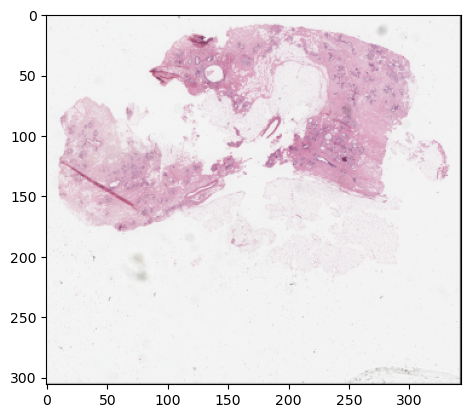

In [24]:
plt.imshow(resized_image)

### Test With Patch Selection

In [13]:
dataset = WSIDataset(
    wsi_path=WSI_PATH,
    patch_size=PATCH_SIZE,
    coords_path=COORDS_PATH,
    transform=transform,
)

In [15]:
dataloader = DataLoader(dataset=dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

In [18]:
resized_image = resize(loader=dataloader)

  0%|          | 0/746 [00:00<?, ?it/s]

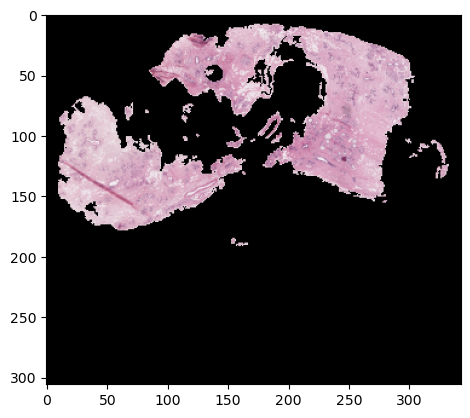

In [19]:
plt.imshow(resized_image)